# Preparation of CDR3 amino acid phenotypes

In this tutorial, I will explain how we created CDR3 amino acid (AA) phenotypes in our manuscript (**Ishigaki et al. Nature Genetics 2022**; **"CDR3 phenotype 2"** in the following script). 
In the actual analysis, the work is done using an AWK script. However, to make our strategy more transparent, I here provided the R code.
<br>
The CDR3 AA phenotypes in this tutorial is a **20-dimensional vector** derived from one sample: each AA has its frequency information (the sum of all frequencies is 1). This 20-dimensional vector is the response variable in the multivariate multiple linear regression (MMLM) in our manuscript (**right panel** in the below figure). Each component of this vector (frequency data of one specific amino acid) is the response variable in the linear model (LM) in our manuscript (**left panel** in the below figure).
<br>
Also, I will introduce alternative ways of preparing CDR3 AA phenotypes, which may be useful for projects with a limited number of CDR3 sequences including single cell data. 

<img src="./image1.png" width="600">

## Prepare data to analyze

In [1]:
#V genes used in this analysis
keep_vgene <- as.character(read.table("../data/tcr_phenotype/demo/V_all.txt")[,1])
head(keep_vgene,n=2)
length(keep_vgene)

[1] "TCRBV01-01" "TCRBV02-01"

[1] 60

In [2]:
#J genes used in this analysis
keep_jgene <- as.character(read.table("../data/tcr_phenotype/demo/J_all.txt")[,1])
head(keep_jgene,n=2)
length(keep_jgene)

[1] "TCRBJ01-01" "TCRBJ01-02"

[1] 13

In [4]:
#An example TCR-CDR3 data
tdata <- read.table("../data/tcr_phenotype/demo/test_data.txt.gz",
                    header=T,colClasses="character")
tdata$Length <- nchar(tdata$CDR3)
head(tdata,n=3)
#1st column: CDR3 amino acid (AA) sequences starting from C and ending with F
#2nd column: V gene
#3rd column: J gene
#4th column: length of CDR3 amino acids

CDR3,Vgene,Jgene,Length
CSVEESYEQYF,TCRBV29-01,TCRBJ02-07,11
CATTGTSGGPSQSTQYF,TCRBV10-03,TCRBJ02-03,17
CASSLRVGGYGYTF,TCRBV07-09,TCRBJ01-02,14


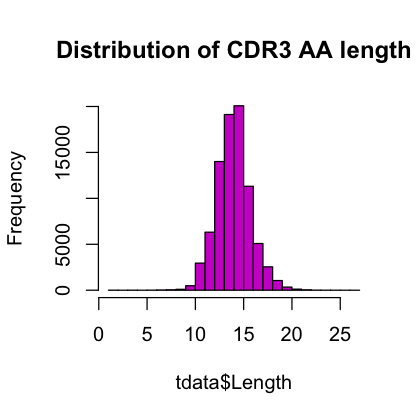

In [9]:
#CDR3 has variable length
options(repr.plot.width=3.5, repr.plot.height=3.5)
hist(tdata$Length,breaks=20,main="Distribution of CDR3 AA length",col="magenta3")

## QC of TCR data

In [10]:
#QC1, CDR3 length 12-18
nrow(tdata)
tdata <- subset(tdata, Length >= 12 & Length <=18)
nrow(tdata)

[1] 83689

[1] 78472

In [11]:
#QC2, V gene with positional AA information
nrow(tdata)
tdata <- tdata[ tdata$Vgene %in% keep_vgene,  ]
nrow(tdata)

[1] 78472

[1] 78439

In [12]:
#QC3, J gene with positional AA information
nrow(tdata)
tdata <- tdata[ tdata$Jgene %in% keep_jgene,  ]
nrow(tdata)

[1] 78439

[1] 78439

In [13]:
tdata_qc <- tdata

## CDR3 IMGT position 

One of the most complicated topic in CDR3 is the **positioning definition**. IMGT (https://www.imgt.org/IMGTrepertoire/) provides a reasonable solution illustrated below. The numbers in the table is the CDR3 AA positions in the IMGT definition. 
<br>
The IMGT positions in red is the positions we analyzed in our manuscript (**Ishigaki et al. Nature Genetics 2022**). In total, there are **70** length-position combinations. The center positions are missing in CDR3s less than 15 AAs. On the flip side, we have extra center positions in CDR3s longer than 15 AAs.

<img src="./image2.png" width="400">

In [14]:
#all IMGT positions
all_imgt_pos <- c(
    "P104","P105","P106","P107","P108","P109","P110","P111",
    "P111.1","P112.2","P112.1",
    "P112","P113","P114","P115","P116","P117","P118")
length(all_imgt_pos)

[1] 18

In [15]:
#Custom function to align CDR3 AA seq to IMGT
align_imgt <- function(CDR3){
    AA <- unlist(strsplit(CDR3, ""));
    N_AA_fow <- nchar(CDR3) %/% 2 + nchar(CDR3) %% 2;
    N_AA_na <- 18 - nchar(CDR3);
    AAmod <- c(
        AA[1:(N_AA_fow)],
        rep("NA",N_AA_na),
        AA[(N_AA_fow + 1):nchar(CDR3)]
    );
    names(AAmod) <- all_imgt_pos
    return(t(AAmod))
}

In [16]:
#Example 1: when the AA length of CDR3 = 15, 3 NAs in the middle
input='CATTGTSGSQSTQYF'
nchar(input)
align_imgt(CDR3=input)

[1] 15

P104,P105,P106,P107,P108,P109,P110,P111,P111.1,P112.2,P112.1,P112,P113,P114,P115,P116,P117,P118
C,A,T,T,G,T,S,G,NA,NA,NA,S,Q,S,T,Q,Y,F


In [17]:
#Example 2: when the AA length of CDR3 = 12, 6 NAs in the middle
input='CATTGTQSTQYF'
nchar(input)
align_imgt(CDR3=input)

[1] 12

P104,P105,P106,P107,P108,P109,P110,P111,P111.1,P112.2,P112.1,P112,P113,P114,P115,P116,P117,P118
C,A,T,T,G,T,NA,NA,NA,NA,NA,NA,Q,S,T,Q,Y,F


In [18]:
#Example 3: when the AA length of CDR3 = 18, no NA in the middle
input='CATTGTSGGPGSQSTQYF'
nchar(input)
align_imgt(CDR3=input)

[1] 18

P104,P105,P106,P107,P108,P109,P110,P111,P111.1,P112.2,P112.1,P112,P113,P114,P115,P116,P117,P118
C,A,T,T,G,T,S,G,G,P,G,S,Q,S,T,Q,Y,F


In [19]:
#Add imgt position data to tdata_qc
tdata_imgt_pos <- t(sapply(as.character(tdata_qc$CDR3),align_imgt))
colnames(tdata_imgt_pos) <- all_imgt_pos

tdata_qc_imgt <- data.frame(tdata_qc,tdata_imgt_pos)

In [21]:
#Let's check how it works.
head(tdata_qc,n=3)
head(tdata_qc_imgt,n=3)

,CDR3,Vgene,Jgene,Length
2,CATTGTSGGPSQSTQYF,TCRBV10-03,TCRBJ02-03,17
3,CASSLRVGGYGYTF,TCRBV07-09,TCRBJ01-02,14
4,CASRRLGGLNTEAFF,TCRBV25-01,TCRBJ01-01,15


,CDR3,Vgene,Jgene,Length,P104,P105,P106,P107,P108,P109,⋯,P111.1,P112.2,P112.1,P112,P113,P114,P115,P116,P117,P118
2,CATTGTSGGPSQSTQYF,TCRBV10-03,TCRBJ02-03,17,C,A,T,T,G,T,⋯,G,NA,P,S,Q,S,T,Q,Y,F
3,CASSLRVGGYGYTF,TCRBV07-09,TCRBJ01-02,14,C,A,S,S,L,R,⋯,NA,NA,NA,G,G,Y,G,Y,T,F
4,CASRRLGGLNTEAFF,TCRBV25-01,TCRBJ01-01,15,C,A,S,R,R,L,⋯,NA,NA,NA,L,N,T,E,A,F,F


## CDR3 phenotype 1 (length-position combination)

A very simple and straigtforward way to create CDR3 phenotype is simply focusing on each AA position for each length of CDR3. For each AA position of each length of CDR3, we quantify AA usage ratio. This is **NOT** what we used in our manuscript.
<br>
Since this analysis is stratified by CDR3 length, we expect **a large amount of input CDR3 data** (typically **bulk** TCR sequence data).

In [22]:
#Eample 1: P110 of CDR3 with length 15 AAs
Target_Len <- 15
Target_Pos <- "P110"

Target_AA <- subset(tdata_qc_imgt,Length==Target_Len)[,Target_Pos]
Target_AA <- as.character(Target_AA)
TB <- table(Target_AA)
Ratio <- as.numeric(TB)/length(Target_AA)
out <- data.frame(AA=names(TB),Ratio)
head(out,n=3)

AA,Ratio
A,0.0724854282
C,0.0001494545
D,0.0476759827


## CDR3 phenotype 2 (length-position combination, excluding germ-line V/J AA)

This is what we did in our manuscript (**Ishigaki et al. Nature Genetics 2022**). It is almost same as CDR3 phenotype 1; for each AA position of each length of CDR3, we quantify AA usage ratio. However, we added an additional treatment in this phenotype. **We excluded CDR3-AA that is encoded in the germline sequences of V and J genes**. By doing so, we can exclude V and J gene effects in the CDR3 analysis, which is sometimes very helpful to understand CDR3 biology.
<br>
In our manuscript, we used **70** phenotypes since we included 70 length-position combinations in our analysis (see above discussion).
<br>
Since this analysis is stratified by CDR3 length, we expect **a large amount of input CDR3 data** (typically **bulk** TCR sequence data).
<br>
We refer to the information in the IMGT website for all germline sequences:
<br>
**V genes**: https://www.imgt.org/IMGTrepertoire/Proteins/proteinDisplays.php?species=human&latin=Homo%20sapiens&group=TRBV
**J genes**: https://www.imgt.org/IMGTrepertoire/Proteins/proteinDisplays.php?species=human&latin=Homo%20sapiens&group=TRBJ

In [37]:
#AAs encoded in V gene germline sequences
V_germ_line <- read.table("../data/tcr_phenotype/demo/V_exclude_AA.info",
                         header=T,colClasses="character")
V_germ_line$IMGT <- paste0("P",V_germ_line$IMGT)
V_exclude <- paste0(V_germ_line$Vgene,":",V_germ_line$IMGT,":",V_germ_line$AA)
head(V_exclude,n=3)

[1] "TCRBV01-01:P104:C" "TCRBV01-01:P105:T" "TCRBV01-01:P106:S"

In [29]:
#AAs encoded in J gene germline sequences (we need to consider CDR3 length for J genes)
J_germ_line <- read.table("../data/tcr_phenotype/demo/J_exclude_AA.info",
                         header=T,colClasses="character")
J_germ_line$IMGT <- paste0("P",J_germ_line$IMGT)
J_exclude <- paste0(J_germ_line$Jgene,":L",J_germ_line$Length,":",J_germ_line$IMGT,":",J_germ_line$AA)
head(J_exclude,n=3)

[1] "TCRBJ01-01:L12:P113:N" "TCRBJ01-01:L13:P113:N" "TCRBJ01-01:L14:P113:N"

In [33]:
#Eample 1: P108 of CDR3 with length 15 AA
Target_Len <- 15
Target_Pos <- "P108"

Target_data <- subset(tdata_qc_imgt,Length==Target_Len)[,c(Target_Pos,"Vgene","Jgene","Length")]
colnames(Target_data)[1] <- "AA"
Target_data$V_tag <- paste0(Target_data$Vgene,":",Target_Pos,":",Target_data$AA)
Target_data$J_tag <- paste0(Target_data$Jgene,":L",Target_data$Length,":",Target_Pos,":",Target_data$AA)
head(Target_data,n=2)

,AA,Vgene,Jgene,Length,V_tag,J_tag
4,R,TCRBV25-01,TCRBJ01-01,15,TCRBV25-01:P108:R,TCRBJ01-01:L15:P108:R
8,E,TCRBV02-01,TCRBJ02-02,15,TCRBV02-01:P108:E,TCRBJ02-02:L15:P108:E


In [34]:
#exclude germline V/J sequence
nrow(Target_data)
Target_data <- Target_data[! Target_data$V_tag %in% V_exclude, ]
Target_data <- Target_data[! Target_data$J_tag %in% J_exclude, ]
nrow(Target_data)

[1] 20073

[1] 11989

In [36]:
#calculate the AA usage ratio
Target_AA <- as.character(Target_data$AA)
TB <- table(Target_AA)
Ratio <- as.numeric(TB)/length(Target_AA)
out <- data.frame(AA=names(TB),Ratio)
head(out,n=3)

AA,Ratio
A,0.0717324214
C,0.0003336392
D,0.0428726332


## CDR3 phenotype 3 (position only)

This strategy is focusing on only AA positions (jointly analyzing a CDR3 position **across all length of CDR3**). Since it is not stratified by length, **it maybe appropriate when your data does not have sufficient CDR3 numbers** (eg, **single cell data**).

In [328]:
#Eample 1: P110 of CDR3 (all lengths of CDR3)
Target_Pos <- "P110"

Target_AA <- tdata_qc_imgt[,Target_Pos]
Target_AA <- as.character(Target_AA)
Target_AA <- Target_AA[Target_AA!="NA"]
TB <- table(Target_AA)
Ratio <- as.numeric(TB)/length(Target_AA)
out <- data.frame(AA=names(TB),Ratio)
head(out,n=3)

AA,Ratio
A,0.0663024791
C,0.0001525151
D,0.0398064445


## CDR3 phenotype 4 (middle positions)

This strategy is focusing on only middle AA positions (P108-P112, as we reported in another recent manuscript: **Lagattuta et al. Nature Immunology 2022**), jointly analyzing these positions **across all length of CDR3**. We will obtain **one average frequency** for each AA (one phenotype for each sample).
<br>
Since it is not stratified by length, **it maybe appropriate when your data does not have sufficient CDR3 numbers** (eg, **single cell data**).

In [40]:
all_aa <- c("A", "C", "D", "E", "F", "G", "H", "I", "K", "L", 
            "M", "N", "P", "Q", "R", "S", "T", "V", "W", "Y")
length(all_aa)

[1] 20

In [41]:
#Eample
Target_data <- tdata_qc_imgt[,c("P108","P109","P110","P111","P111.1","P112.2","P112.1","P112"),]
midAA <- t(apply(Target_data,1,function(x){
    x <- as.character(x);
    x <- x[x!="NA"]
    TB <- table(x)
    Ratio <- as.numeric(TB)/length(x)
    names(Ratio) <- names(TB)
    Ratio <- Ratio[all_aa]
    Ratio[is.na(Ratio)] <- 0
    return(Ratio)
}))
colnames(midAA) <- all_aa
head(midAA,n=2)

,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
2,0,0,0,0,0,0.4285714,0,0,0,0.00,0,0,0.1428571,0,0.00,0.2857143,0.1428571,0.00,0,0
3,0,0,0,0,0,0.2500000,0,0,0,0.25,0,0,0.0000000,0,0.25,0.0000000,0.0000000,0.25,0,0


In [42]:
#check dimention
dim(Target_data)
dim(midAA)

[1] 78439     8

[1] 78439    20

In [43]:
#check rowSum (should be 1): ok
summary( apply(midAA,1,function(x){sum(x)}) )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      1       1       1       1       1       1 

In [44]:
#calculate mean of each AA
mean_ratio <- apply(midAA,2,function(x){mean(x)})
out <- data.frame(AA=names(mean_ratio),Ratio=mean_ratio)
head(out,n=3)

,AA,Ratio
A,A,0.0677533315
C,C,0.0002469769
D,D,0.0445584497
